**Add Exogenous features**

You can compute them before training, merge them with your series and then provide the future values.

In [138]:
from mlforecast.utils import generate_series, generate_prices_for_series
from mlforecast.lag_transforms import ExpandingMean
from mlforecast.feature_engineering import transform_exog
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
import matplotlib.pyplot as plt
from mlforecast.callbacks import SaveFeatures

**Import Dataset**

In [111]:
series = generate_series(10, equal_ends=True)
prices = generate_prices_for_series(series)
series.tail(2), prices.tail(2)

(     unique_id         ds         y
 2374         9 2001-05-13  1.388596
 2375         9 2001-05-14  2.061590,
              ds  unique_id     price
 2444 2001-05-20          9  0.149941
 2445 2001-05-21          9  0.754090)

In [112]:
series = series[series.unique_id == 0]
prices = prices[prices.unique_id == 0]

In [113]:
# prices = prices[prices.ds <= series.ds.max()]

In [114]:
series.ds.min(), series.ds.max()

(Timestamp('2000-10-05 00:00:00'), Timestamp('2001-05-14 00:00:00'))

In [115]:
prices.ds.min(), prices.ds.max()

(Timestamp('2000-10-05 00:00:00'), Timestamp('2001-05-21 00:00:00'))

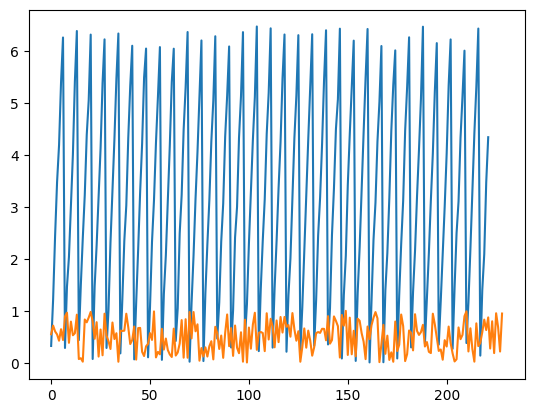

In [116]:
plt.plot(series.y)
plt.plot(prices.price)

In [118]:
# transformed_prices = transform_exog(prices, lags=[7], lag_transforms={1: [ExpandingMean()]})
transformed_prices = transform_exog(prices, lags=[2])
# transformed_prices.drop("price", axis = 1, inplace = True)
transformed_prices.head(10)

,ds,unique_id,price,price_lag2
0,2000-10-05,0,0.548814,NaN
1,2000-10-06,0,0.715189,NaN
2,2000-10-07,0,0.602763,0.548814
3,2000-10-08,0,0.544883,0.715189
4,2000-10-09,0,0.423655,0.602763
5,2000-10-10,0,0.645894,0.544883
6,2000-10-11,0,0.437587,0.423655
7,2000-10-12,0,0.891773,0.645894
8,2000-10-13,0,0.963663,0.437587
9,2000-10-14,0,0.383442,0.891773


In [119]:
series_with_prices = series.merge(transformed_prices, on=['unique_id', 'ds'])
series_with_prices.head(10)

,unique_id,ds,y,price,price_lag2
0,0,2000-10-05,0.322947,0.548814,NaN
1,0,2000-10-06,1.218794,0.715189,NaN
2,0,2000-10-07,2.445887,0.602763,0.548814
3,0,2000-10-08,3.481831,0.544883,0.715189
4,0,2000-10-09,4.191721,0.423655,0.602763
5,0,2000-10-10,5.395863,0.645894,0.544883
6,0,2000-10-11,6.264447,0.437587,0.423655
7,0,2000-10-12,0.284022,0.891773,0.645894
8,0,2000-10-13,1.462798,0.963663,0.437587
9,0,2000-10-14,2.035518,0.383442,0.891773


In [121]:
series_with_prices.ds.max(), transformed_prices.ds.max()

(Timestamp('2001-05-14 00:00:00'), Timestamp('2001-05-21 00:00:00'))

In [122]:
fcst = MLForecast(
    models=[LinearRegression()],
    freq='D',
    lags=[1],
    date_features=['dayofweek'],
)
_prep = fcst.preprocess(series_with_prices, static_features=[], dropna=True)
_prep.head()

,unique_id,ds,y,price,price_lag2,lag1,dayofweek
1,0,2000-10-06,1.218794,0.715189,NaN,0.322947,4
2,0,2000-10-07,2.445887,0.602763,0.548814,1.218794,5
3,0,2000-10-08,3.481831,0.544883,0.715189,2.445887,6
4,0,2000-10-09,4.191721,0.423655,0.602763,3.481831,0
5,0,2000-10-10,5.395863,0.645894,0.544883,4.191721,1


In [123]:
X, y = fcst.preprocess(series_with_prices, static_features=[], dropna=True, return_X_y=True)

In [124]:
X

,price,price_lag2,lag1,dayofweek
1,0.715189,NaN,0.322947,4
2,0.602763,0.548814,1.218794,5
3,0.544883,0.715189,2.445887,6
4,0.423655,0.602763,3.481831,0
5,0.645894,0.544883,4.191721,1
...,...,...,...,...
217,0.383464,0.758379,6.436325,3
218,0.588317,0.320017,0.136771,4
219,0.831048,0.383464,1.399023,5
220,0.628982,0.588317,2.092818,6


In [127]:
y

array([1.21879361e+00, 2.44588650e+00, 3.48183138e+00, 4.19172076e+00,
       5.39586252e+00, 6.26444746e+00, 2.84022281e-01, 1.46279832e+00,
       2.03551803e+00, 3.04356465e+00, 4.01010920e+00, 5.41630992e+00,
       6.38907838e+00, 4.35006074e-01, 1.48930917e+00, 2.39957928e+00,
       3.23073968e+00, 4.39026459e+00, 5.05913721e+00, 6.31996051e+00,
       7.16766437e-02, 1.47233446e+00, 2.26092416e+00, 3.20733097e+00,
       4.13227781e+00, 5.38711684e+00, 6.22807517e+00, 2.84216974e-01,
       1.00939490e+00, 2.30881775e+00, 3.30604786e+00, 4.30846700e+00,
       5.47187404e+00, 6.34091015e+00, 1.79753950e-01, 1.21851598e+00,
       2.34881560e+00, 3.03011274e+00, 4.33338336e+00, 5.33531893e+00,
       6.10519128e+00, 6.44631488e-02, 1.15771418e+00, 2.18185539e+00,
       3.28509839e+00, 4.21930076e+00, 5.49418692e+00, 6.05102241e+00,
       1.04438378e-01, 1.08065476e+00, 2.32655416e+00, 3.12664580e+00,
       4.23315539e+00, 5.12221280e+00, 6.07948479e+00, 5.51875706e-02,
      

In [128]:
_prep.tail()

,unique_id,ds,y,price,price_lag2,lag1,dayofweek
217,0,2001-05-10,0.136771,0.383464,0.758379,6.436325,3
218,0,2001-05-11,1.399023,0.588317,0.320017,0.136771,4
219,0,2001-05-12,2.092818,0.831048,0.383464,1.399023,5
220,0,2001-05-13,3.476396,0.628982,0.588317,2.092818,6
221,0,2001-05-14,4.343744,0.872651,0.831048,3.476396,0


In [129]:
series_with_prices2 = series_with_prices.dropna()
fcst.preprocess(series_with_prices2, dropna=True, static_features=[]).head()

,unique_id,ds,y,price,price_lag2,lag1,dayofweek
3,0,2000-10-08,3.481831,0.544883,0.715189,2.445887,6
4,0,2000-10-09,4.191721,0.423655,0.602763,3.481831,0
5,0,2000-10-10,5.395863,0.645894,0.544883,4.191721,1
6,0,2000-10-11,6.264447,0.437587,0.423655,5.395863,2
7,0,2000-10-12,0.284022,0.891773,0.645894,6.264447,3


In [130]:
series_with_prices2.unique_id.unique()

array([0])

In [133]:
series_with_prices2.tail()

,unique_id,ds,y,price,price_lag2
217,0,2001-05-10,0.136771,0.383464,0.758379
218,0,2001-05-11,1.399023,0.588317,0.320017
219,0,2001-05-12,2.092818,0.831048,0.383464
220,0,2001-05-13,3.476396,0.628982,0.588317
221,0,2001-05-14,4.343744,0.872651,0.831048


In [131]:
fcst.fit(series_with_prices2, static_features=[], max_horizon=6)

MLForecast(models=[LinearRegression], freq=D, lag_features=['lag1'], date_features=['dayofweek'], num_threads=1)

In [136]:
transformed_prices.tail(7)

,ds,unique_id,price,price_lag2
222,2001-05-15,0,0.273542,0.628982
223,2001-05-16,0,0.798047,0.872651
224,2001-05-17,0,0.185636,0.273542
225,2001-05-18,0,0.952792,0.798047
226,2001-05-19,0,0.687488,0.185636
227,2001-05-20,0,0.215508,0.952792
228,2001-05-21,0,0.947371,0.687488


In [139]:
def inspect_input(new_x):
    """Displays the model inputs to inspect them"""
    display(new_x)
    return new_x

save_feats = SaveFeatures()

fcst.predict(6, X_df=transformed_prices.dropna(), before_predict_callback=save_feats)

,unique_id,ds,LinearRegression
0,0,2001-05-15,4.248336
1,0,2001-05-16,3.599964
2,0,2001-05-17,2.506314
3,0,2001-05-18,1.231995
4,0,2001-05-19,2.833854
5,0,2001-05-20,3.946717


In [140]:
features = save_feats.get_features()
features.head()

,price,price_lag2,lag1,dayofweek
0,0.273542,0.628982,4.343744,1
